In [2]:
import os
import cv2
import json
import uuid
import numpy as np
import pandas as pd
from glob import glob 
import tensorflow as tf
# from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from model_construction.model_test import model
model = model(img_height=384, img_width=508, classes=2)
model.load_weights(r'C:\Users\noahorfx\Desktop\Project_Code\Fetal_Ultrasound_Segmentation\src\model_construction\weights.h5')

*** Output Shape: (None, 384, 508, 2) ***


In [24]:
from dataset_construction.calculate_ac_from_mask import *

In [25]:
mask_dir = "../../training_data/masks_pred"
output_json = "../../training_data/ac_pred_complete.json"
ac_pred = {}

mask_files = sorted(glob(os.path.join(mask_dir, "*.png")))

for path in mask_files:
    filename = os.path.basename(path)
    try:
        temp_path = f"temp_smooth_{uuid.uuid4().hex[:8]}.png"
        smoothed_path = preprocess_and_save_smoothed_mask(path, out_path=temp_path, ksize=(71,71), sigma=4)
        # smoothed_path = refine_mask_with_snake(path, out_path=temp_path)
        ac_value = fit_ellipse_ac_mm_pred(smoothed_path, show_plot=False, scale_factor=1, epsilon=0.0015)
        # ac_value = fit_circle_ac_mm(mask_path, show_plot=False, scale_factor=0.965)
        
        ac_pred[filename] = {"ac_mm": round(ac_value, 2)}
        os.remove(temp_path)
    except Exception as e:
        ac_pred[filename] = {"ac_mm": None}
        print(f"{filename} fitting error: {e}")

with open(output_json, "w") as f:
    json.dump(ac_pred, f, indent=2)

print(f"AC calculation completed: {len(mask_files)} images processed. Results saved to {output_json}")


AC calculation completed: 6620 images processed. Results saved to ../../training_data/ac_pred_complete.json


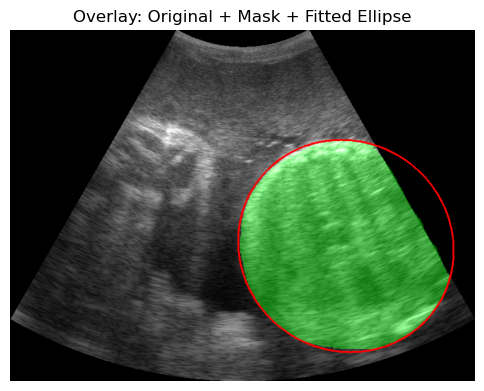

Fit ellipse ≈ 301.50 mm


In [26]:
mask_path = "../../training_data/masks_pred/frame_000011.png"
smoothed_path = preprocess_and_save_smoothed_mask(mask_path, out_path="smoothed_temp.png", ksize=(71,71), sigma=4)
perimeter = fit_ellipse_ac_mm_pred(mask_path, show_plot=True, scale_factor=1, epsilon=0.01)
print(f"Fit ellipse ≈ {perimeter:.2f} mm")

In [43]:
ellipse_info_path = "../../training_data/ellipse_info_checked.json"
ac_gt_path = "../../training_data/ac_results.json"
ac_pred_path = "../../training_data/ac_pred_complete.json"
output_csv_path = "./results_by_completeimages/ac_train_data.csv"

with open(ellipse_info_path, "r") as f:
    ellipse_info = json.load(f)
with open(ac_gt_path, "r") as f:
    ac_gt = json.load(f)
with open(ac_pred_path, "r") as f:
    ac_pred = json.load(f)

data = []
for fname in ac_gt:
    if (
        fname in ac_pred and
        fname in ellipse_info and
        ellipse_info[fname]["is_complete"] and
        ac_gt[fname]["ac_mm"] is not None and
        ac_pred[fname]["ac_mm"] is not None
    ):
        gt = ac_gt[fname]["ac_mm"]
        pred = ac_pred[fname]["ac_mm"]
        res = gt - pred
        data.append({
            "filename": fname,
            "image_path": os.path.join("../../training_data/segmentation_dataset/images", fname),
            "mask_path": os.path.join("../../training_data/masks_pred", fname),
            "ac_gt": gt,
            "ac_pred": pred,
            "ac_residual": res
        })

os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
df = pd.DataFrame(data)
df.to_csv(output_csv_path, index=False)

In [28]:
IMG_SIZE = (562, 744)
AUTOTUNE = tf.data.AUTOTUNE

def parse_row(image_path, mask_path_d, ac_pred_d, residual):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # 归一化到 [0, 1]

    mask_raw = tf.io.read_file(mask_path_d)
    mask = tf.image.decode_png(mask_raw, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.float32)

    mask_max = tf.reduce_max(mask)
    mask_min = tf.reduce_min(mask)
    mask_bin = tf.cond(
        mask_max <= 1.0,
        lambda: tf.where(mask > 0.5, 1.0, 0.0),
        lambda: tf.where(mask > 127, 1.0, 0.0)
    )

    x = tf.concat([image, mask_bin], axis=-1)  # shape: (H, W, 4)

    ac_pred_d = tf.cast(ac_pred_d, tf.float32)
    ac_pred_d = tf.reshape(ac_pred_d, (1,))

    y = tf.cast(residual, tf.float32)
    y = tf.reshape(y, (1,))

    return (x, ac_pred_d), y

def create_dataset(csv_path, batch_size=32, shuffle=True):
    df_d = pd.read_csv(csv_path)

    paths_ds = tf.data.Dataset.from_tensor_slices((
        df_d["image_path"].values,
        df_d["mask_path"].values,
        df_d["ac_pred"].values,
        df_d["ac_residual"].values
    ))

    ds = paths_ds.map(parse_row, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df_d))

    return ds.batch(batch_size).prefetch(AUTOTUNE)

df = pd.read_csv("./results_by_completeimages/ac_train_data.csv")
train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, random_state=42)

train_df.to_csv("./results_by_completeimages/ac_train.csv", index=False)
val_df.to_csv("./results_by_completeimages/ac_val.csv", index=False)
test_df.to_csv("./results_by_completeimages/ac_test.csv", index=False)

In [29]:
train_ds = create_dataset("./results/ac_train.csv", batch_size=16, shuffle=True)
val_ds   = create_dataset("./results/ac_val.csv", batch_size=16, shuffle=False)
test_ds  = create_dataset("./results/ac_test.csv", batch_size=16, shuffle=False)

In [30]:
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Concatenate)


def build_residual_model(input_shape=(562, 744, 4)):
    img_mask_input = Input(shape=input_shape, name="img_mask_input")

    ac_pred_input = Input(shape=(1,), name="ac_pred_input")

    x = Conv2D(32, 3, activation='relu')(img_mask_input)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)

    x = Concatenate()([x, ac_pred_input])

    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1, name="residual_output")(x)

    model_p = Model(inputs=[img_mask_input, ac_pred_input], outputs=output)
    return model_p


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = build_residual_model()
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbacks)

Epoch 1/50
290/290 [==============================] - 87s 218ms/step - loss: 4.5687 - mse: 42.1990 - val_loss: 3.2124 - val_mse: 20.0592 - lr: 0.0010
Epoch 2/50
290/290 [==============================] - 87s 216ms/step - loss: 3.3024 - mse: 23.1667 - val_loss: 3.4938 - val_mse: 22.7842 - lr: 0.0010
Epoch 3/50
290/290 [==============================] - 83s 206ms/step - loss: 2.8467 - mse: 17.5296 - val_loss: 2.8134 - val_mse: 15.4315 - lr: 0.0010
Epoch 4/50
290/290 [==============================] - 82s 209ms/step - loss: 2.5561 - mse: 14.5920 - val_loss: 2.6543 - val_mse: 13.4973 - lr: 0.0010
Epoch 5/50
290/290 [==============================] - 83s 207ms/step - loss: 2.4093 - mse: 13.3564 - val_loss: 2.6403 - val_mse: 13.0815 - lr: 0.0010
Epoch 6/50
290/290 [==============================] - 88s 208ms/step - loss: 2.1962 - mse: 11.7127 - val_loss: 2.5393 - val_mse: 12.2616 - lr: 0.0010
Epoch 7/50
290/290 [==============================] - 83s 204ms/step - loss: 2.1049 - mse: 10.8479 -

In [34]:
all_ac_pred = []
all_ac_final = []
all_ac_gt = []

for (x_batch, ac_pred_batch), y_batch in test_ds:
    residual_pred = model.predict([x_batch, ac_pred_batch], verbose=0)
    
    ac_pred_np = ac_pred_batch.numpy().flatten()
    residual_np = residual_pred.flatten()
    ac_gt_np = (ac_pred_np + y_batch.numpy().flatten())

    ac_final = ac_pred_np + residual_np

    all_ac_pred.extend(ac_pred_np.tolist())
    all_ac_final.extend(ac_final.tolist())
    all_ac_gt.extend(ac_gt_np.tolist())

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

mae = mean_absolute_error(all_ac_gt, all_ac_final)
mse = mean_squared_error(all_ac_gt, all_ac_final)
rmse = math.sqrt(mse)

print(f"Test Set Performance:")
print(f"MAE  = {mae:.2f} mm")
print(f"MSE  = {mse:.2f} mm²")
print(f"RMSE = {rmse:.2f} mm")


Test Set Performance:
MAE  = 2.45 mm
MSE  = 12.50 mm²
RMSE = 3.54 mm


In [36]:
df_out = pd.DataFrame({
    "ac_pred": all_ac_pred,
    "residual_pred": np.array(all_ac_final) - np.array(all_ac_pred),
    "ac_final": all_ac_final,
    "ac_gt": all_ac_gt,
    "abs_error": np.abs(np.array(all_ac_gt) - np.array(all_ac_final))
})

df_out.to_csv("./results_by_completeimages/ac_test_complete_results.csv", index=False)

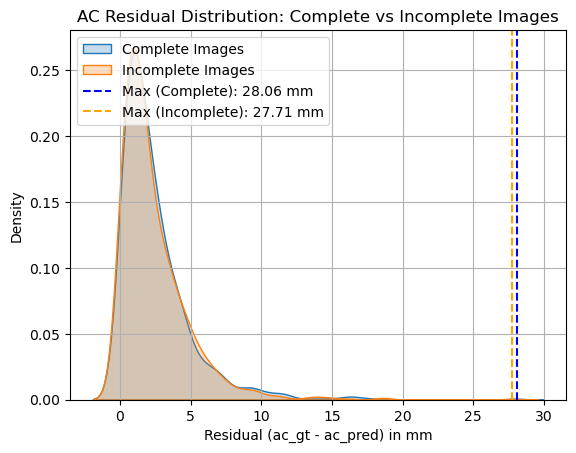

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取 CSV
df_complete = pd.read_csv("./results_by_completeimages/ac_test_complete_results.csv")
df_incomplete = pd.read_csv("./results_by_completeimages/ac_test_incomplete_results.csv")

# 假设有列名为 ac_residual（真实值 - 预测值）
sns.kdeplot(df_complete["abs_error"], label="Complete Images", fill=True)
sns.kdeplot(df_incomplete["abs_error"], label="Incomplete Images", fill=True)

max_err_complete = df_complete["abs_error"].max()
max_err_incomplete = df_incomplete["abs_error"].max()

plt.axvline(max_err_complete, color='blue', linestyle='--', label=f"Max (Complete): {max_err_complete:.2f} mm")
plt.axvline(max_err_incomplete, color='orange', linestyle='--', label=f"Max (Incomplete): {max_err_incomplete:.2f} mm")

plt.title("AC Residual Distribution: Complete vs Incomplete Images")
plt.xlabel("Residual (ac_gt - ac_pred) in mm")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()

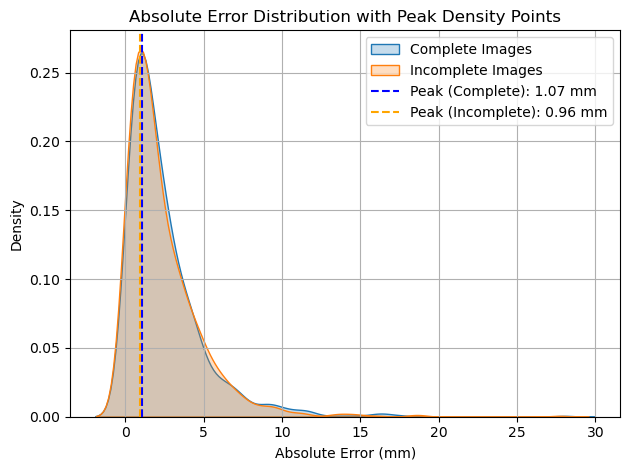

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

df_complete = pd.read_csv("./results_by_completeimages/ac_test_complete_results.csv")
df_incomplete = pd.read_csv("./results_by_completeimages/ac_test_incomplete_results.csv")

x_c = df_complete["abs_error"].dropna()
x_i = df_incomplete["abs_error"].dropna()

kde_c = gaussian_kde(x_c)
kde_i = gaussian_kde(x_i)

x_grid = np.linspace(0, max(x_c.max(), x_i.max()), 500)

peak_c = x_grid[np.argmax(kde_c(x_grid))]
peak_i = x_grid[np.argmax(kde_i(x_grid))]

sns.kdeplot(x_c, label="Complete Images", fill=True)
sns.kdeplot(x_i, label="Incomplete Images", fill=True)

plt.axvline(peak_c, color='blue', linestyle='--', label=f"Peak (Complete): {peak_c:.2f} mm")
plt.axvline(peak_i, color='orange', linestyle='--', label=f"Peak (Incomplete): {peak_i:.2f} mm")

plt.title("Absolute Error Distribution with Peak Density Points")
plt.xlabel("Absolute Error (mm)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


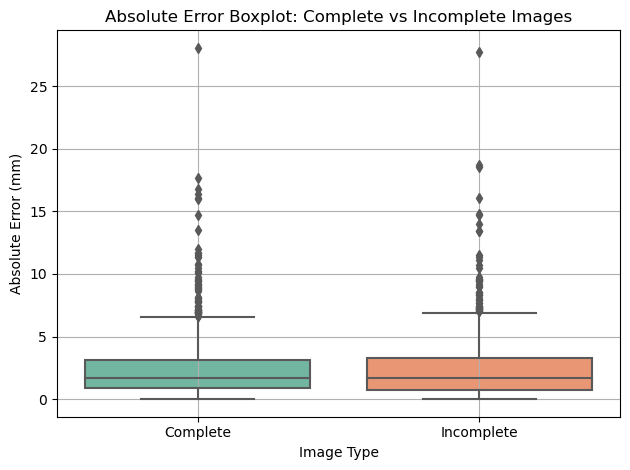

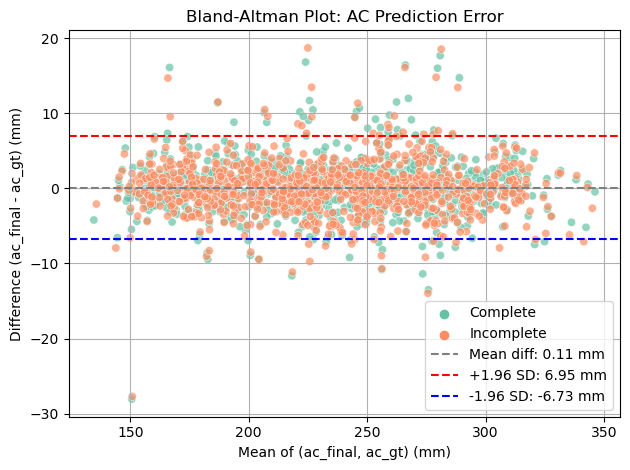

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_complete = pd.read_csv("./results_by_completeimages/ac_test_complete_results.csv")
df_incomplete = pd.read_csv("./results_by_completeimages/ac_test_incomplete_results.csv")

df_complete["type"] = "Complete"
df_incomplete["type"] = "Incomplete"

df_all = pd.concat([df_complete, df_incomplete], ignore_index=True)

sns.boxplot(data=df_all, x="type", y="abs_error", palette="Set2")
plt.title("Absolute Error Boxplot: Complete vs Incomplete Images")
plt.xlabel("Image Type")
plt.ylabel("Absolute Error (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

mean_vals = (df_all["ac_final"] + df_all["ac_gt"]) / 2
diff_vals = df_all["ac_final"] - df_all["ac_gt"]

mean_diff = np.mean(diff_vals)
std_diff = np.std(diff_vals)

loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

sns.scatterplot(x=mean_vals, y=diff_vals, hue=df_all["type"], palette="Set2", alpha=0.7)

plt.axhline(mean_diff, color="gray", linestyle="--", label=f"Mean diff: {mean_diff:.2f} mm")
plt.axhline(loa_upper, color="red", linestyle="--", label=f"+1.96 SD: {loa_upper:.2f} mm")
plt.axhline(loa_lower, color="blue", linestyle="--", label=f"-1.96 SD: {loa_lower:.2f} mm")

plt.title("Bland-Altman Plot: AC Prediction Error")
plt.xlabel("Mean of (ac_final, ac_gt) (mm)")
plt.ylabel("Difference (ac_final - ac_gt) (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
